# Inspect the single-lineage model run on the prostate data (002)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-002_PYMC_NUMPYRO"

In [54]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-prostate-002'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-002",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad. This model builds on 001 with a variable for the mutation of the target gene and a variable for the mutation of cancer genes. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1000,
            "chains": 4,
            "target_accept": 0.97,
            "progress_bar": true,
            "chain_method": "parallel",
            "postprocessing_backend": "cpu",
    

### Load posterior summary

In [6]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0      mu_mu_a  0.099  0.020     0.077      0.121      0.010    0.008   
1         mu_b  0.001  0.003    -0.003      0.004      0.001    0.001   
2         mu_d -0.020  0.001    -0.022     -0.018      0.001    0.000   
3         mu_f  0.067  0.077     0.011      0.201      0.038    0.029   
4  mu_h[ZFHX3] -0.024  0.017    -0.043     -0.006      0.008    0.006   

   ess_bulk  ess_tail  r_hat var_name  
0       5.0      12.0   2.14  mu_mu_a  
1       5.0      28.0   2.10     mu_b  
2       6.0      48.0   2.01     mu_d  
3       5.0      11.0   2.87     mu_f  
4       5.0      11.0   2.24     mu_h

### Load trace object

In [21]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [8]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [9]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [10]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [11]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/27/22 09:24:47] INFO     Processing data for modeling.     ]8;id=899024;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=860682;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=333761;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=858955;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

[07/27/22 09:26:10] WARNING  number of data points dropped: 2  ]8;id=429242;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=443006;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

[07/27/22 09:26:11] INFO     number of genes mutated in all    ]8;id=832522;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=985696;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#470\470]8;;\
                             cells lines: 0                                                  

                    INFO     Dropping 8 cancer genes.          ]8;id=557216;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=360924;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#526\526]8;;\

## Analysis

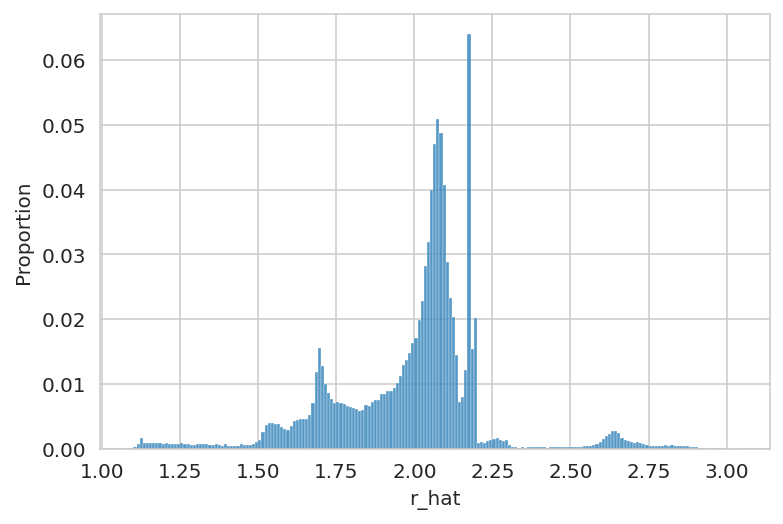

In [12]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

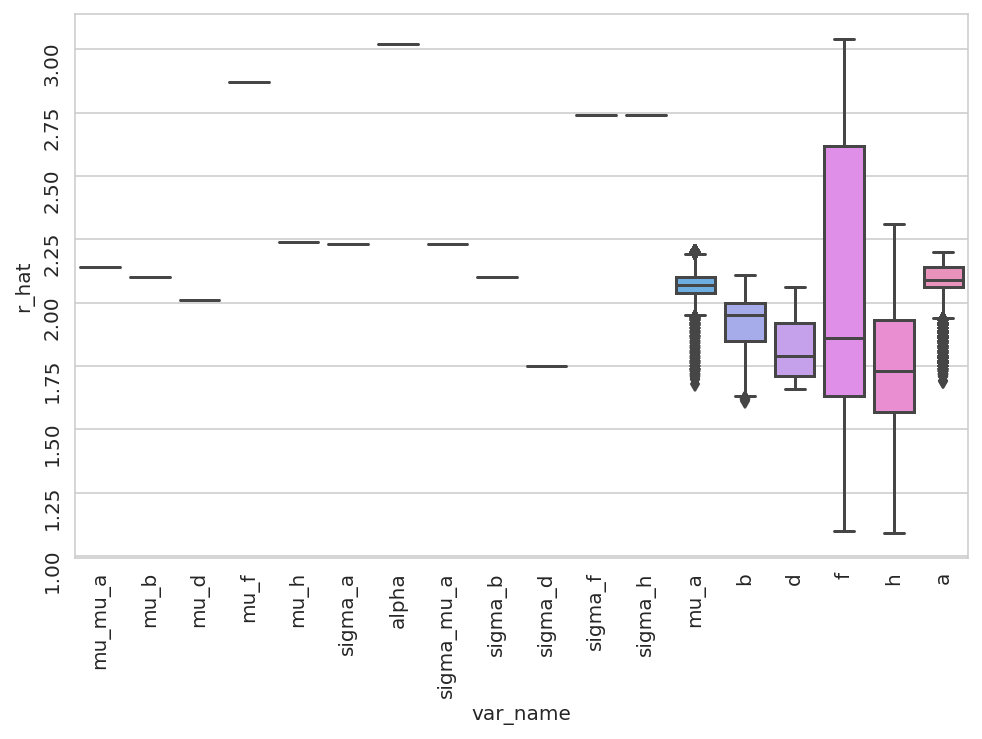

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

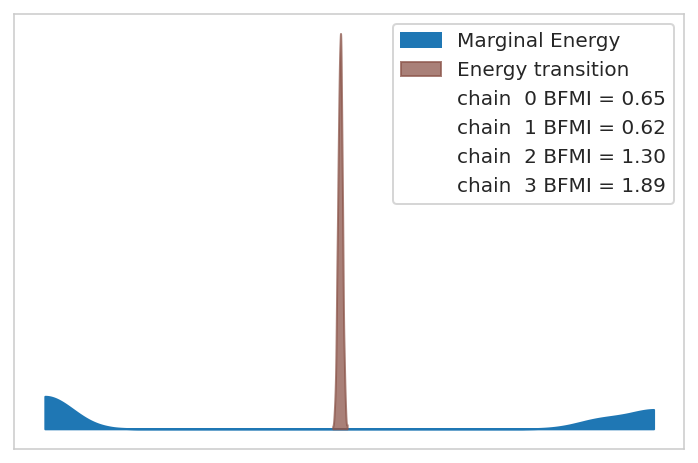

In [22]:
az.plot_energy(trace);

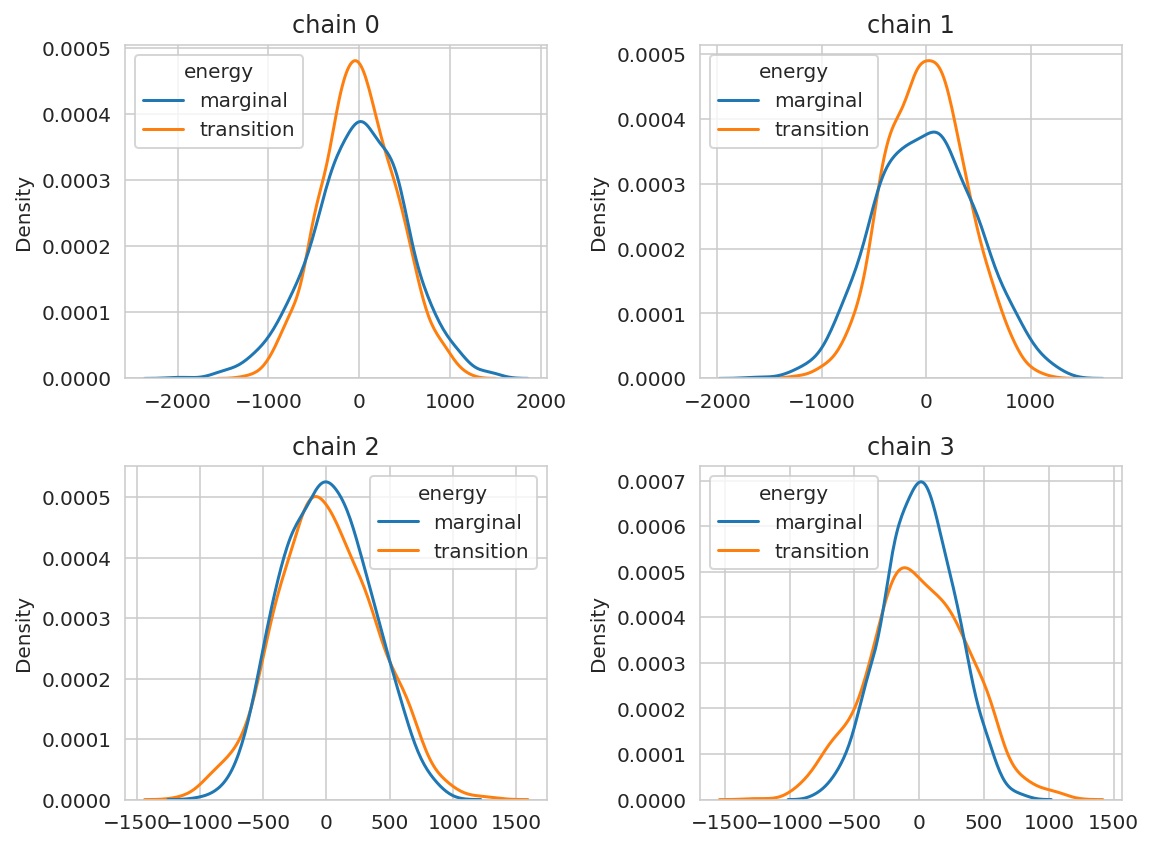

In [23]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i}")
    ax.set_xlabel(None)

fig.tight_layout()
plt.show()

In [24]:
HAPPY_CHAINS = [0, 1]
UNHAPPY_CHAINS = [2, 3]

trace.posterior = trace.posterior.drop_sel(chain=UNHAPPY_CHAINS)
trace.sample_stats = trace.sample_stats.drop_sel(chain=UNHAPPY_CHAINS)
trace.posterior_predictive = trace.posterior_predictive.drop_sel(chain=UNHAPPY_CHAINS)

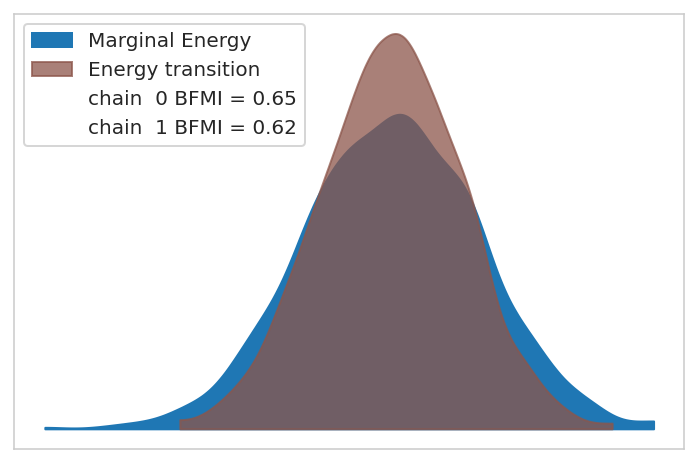

In [25]:
az.plot_energy(trace);

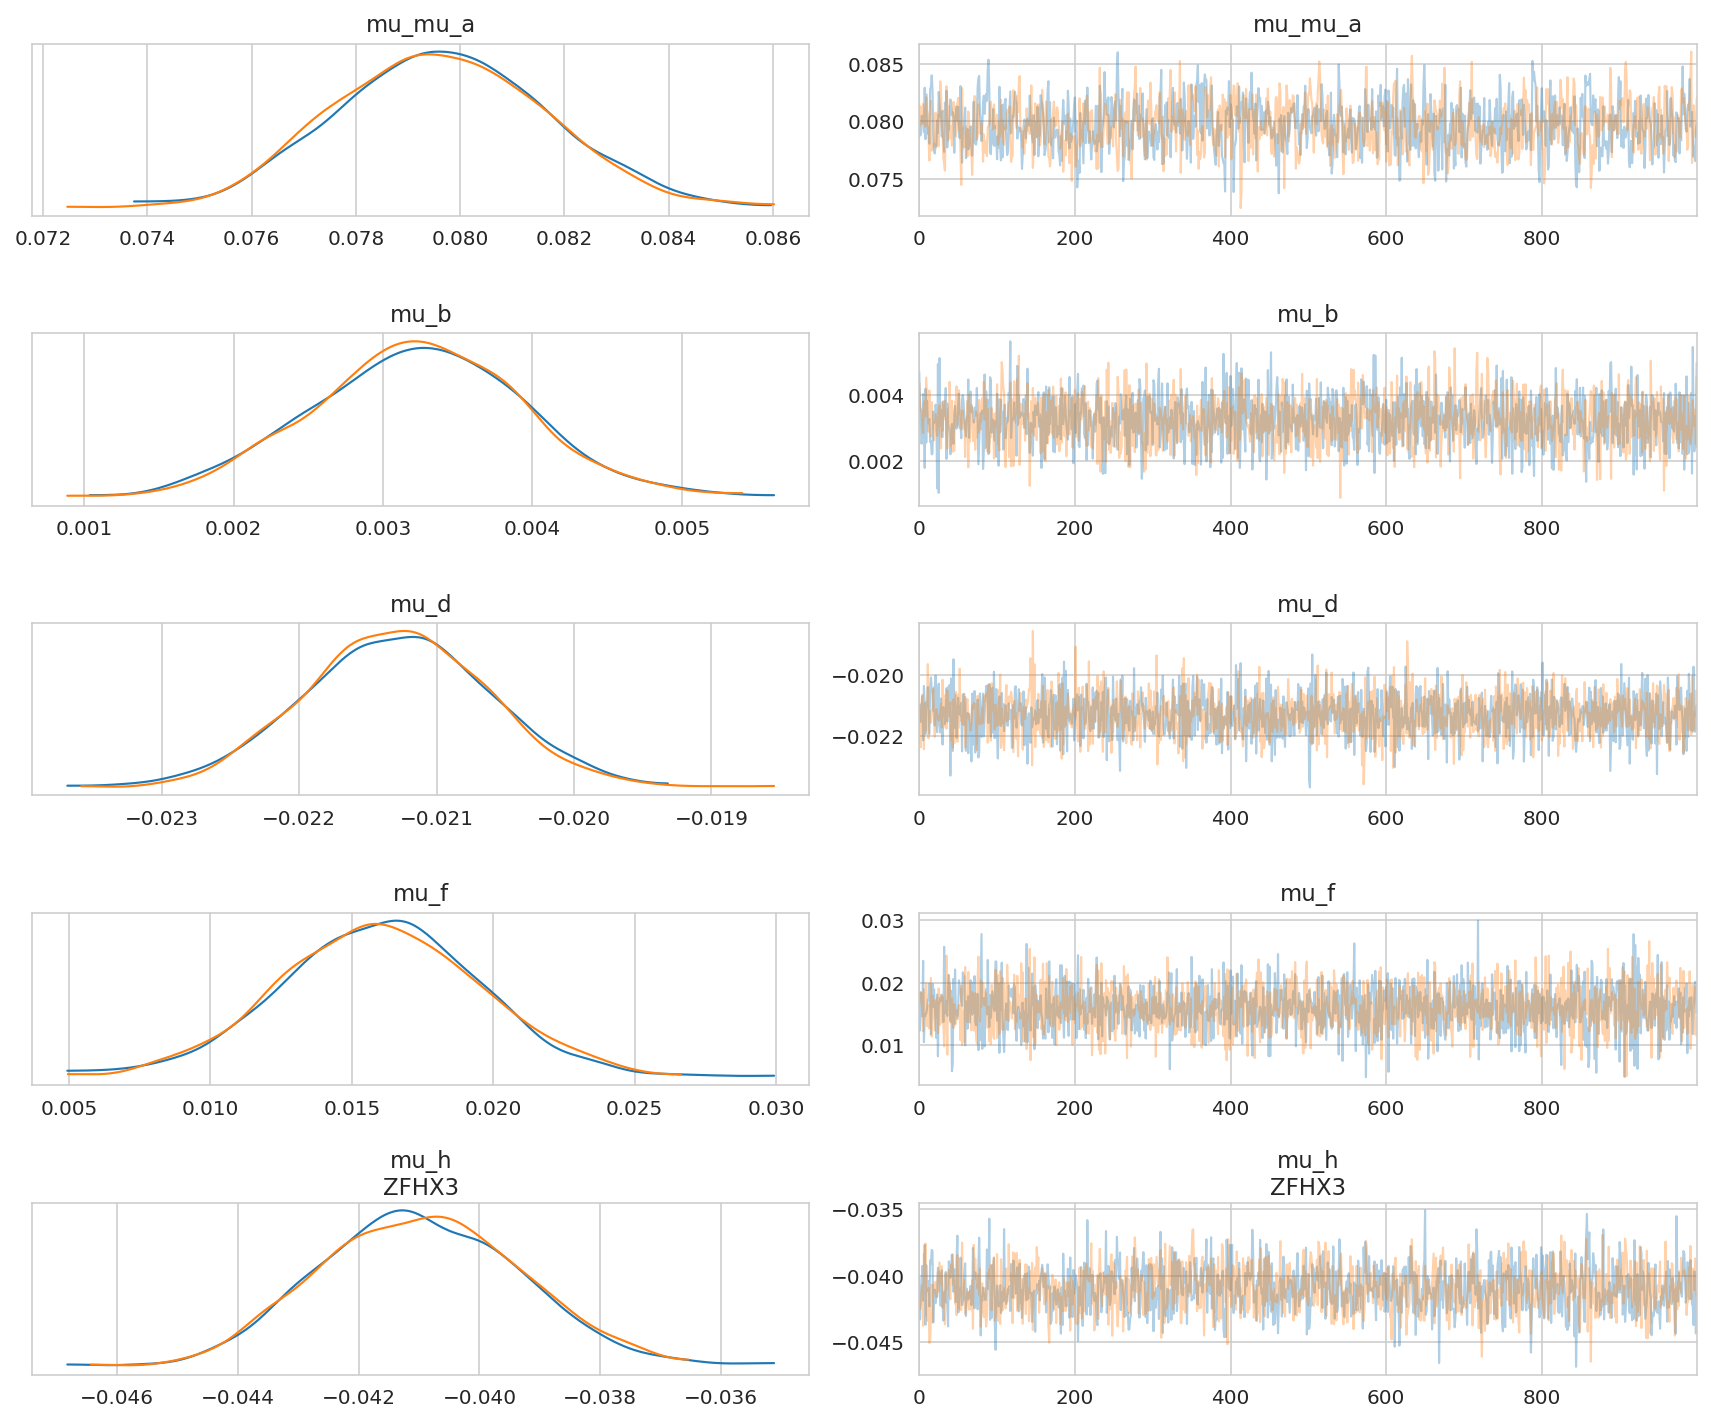

In [26]:
az.plot_trace(
    trace, var_names=["mu_mu_a", "mu_b", "mu_d", "mu_f", "mu_h"], compact=False
)
plt.tight_layout()

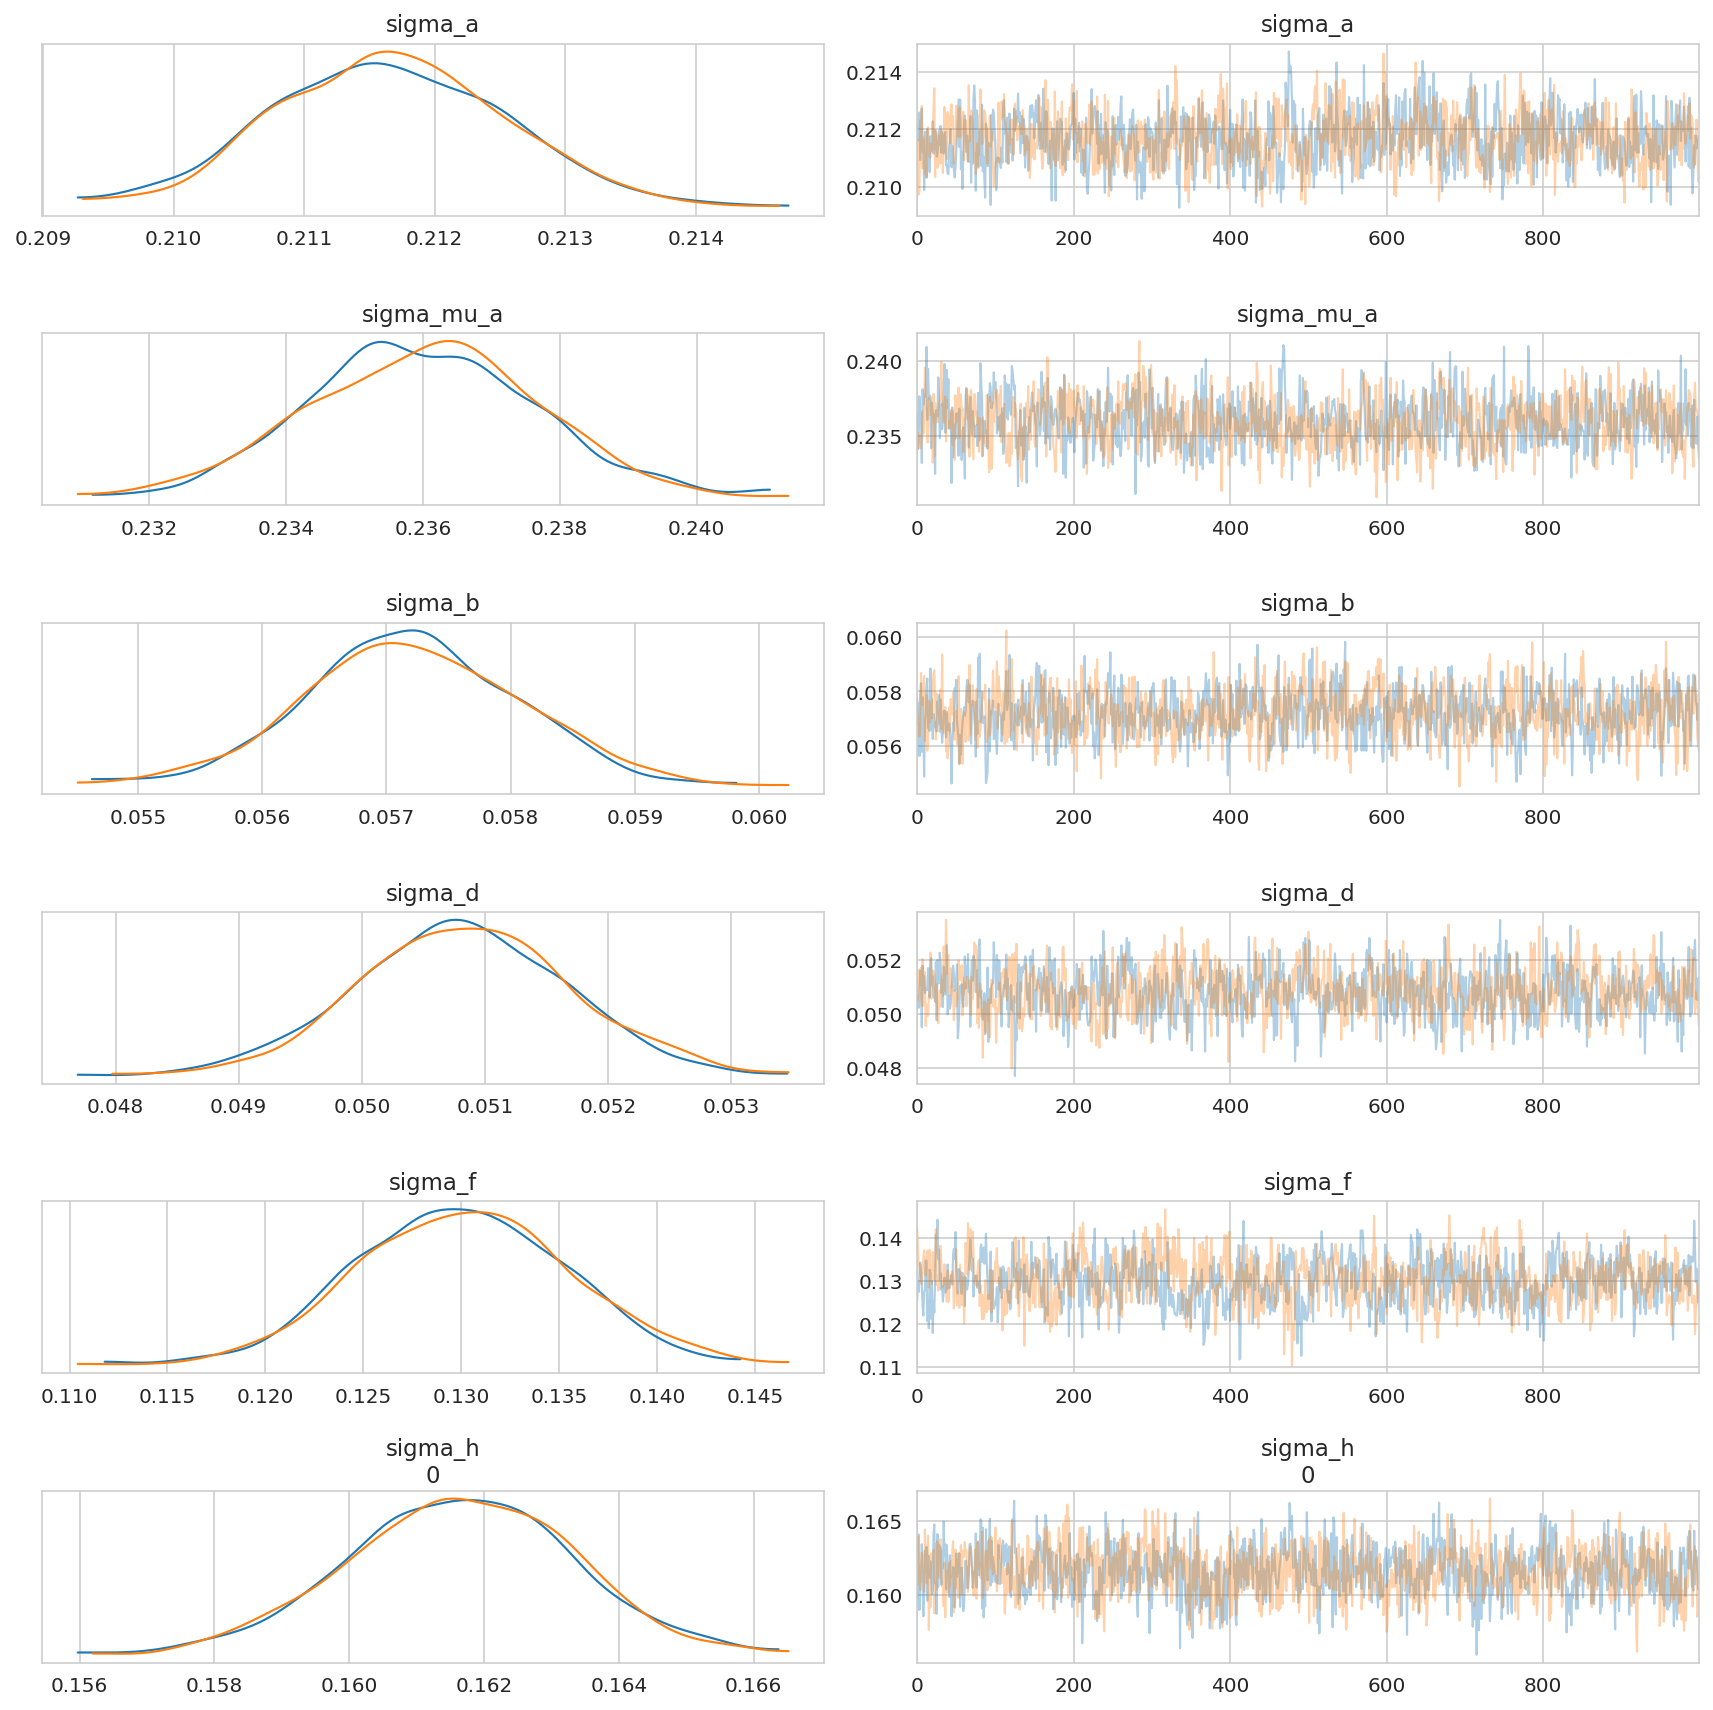

In [27]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

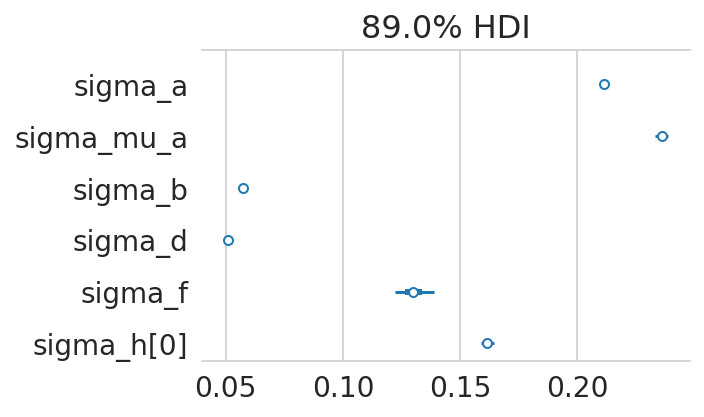

In [28]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=True, figsize=(5, 3)
)
plt.tight_layout()

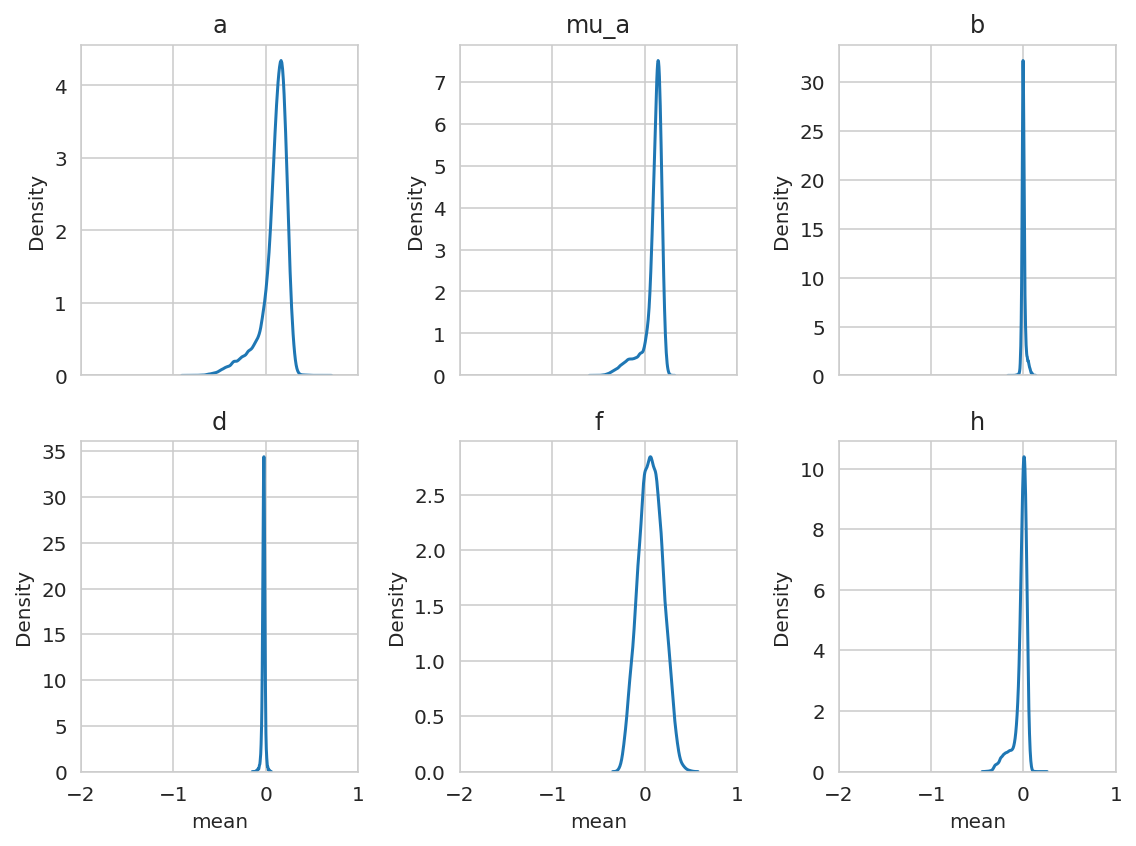

In [29]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [30]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [31]:
az.summary(trace, var_names="mu_a").sort_values("mean").pipe(head_tail, n=5)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
mu_a[KIF11]    -1.222  0.101    -1.359     -1.037      0.002    0.002   
mu_a[HSPE1]    -1.045  0.097    -1.206     -0.888      0.002    0.001   
mu_a[SPC24]    -1.040  0.102    -1.205     -0.883      0.002    0.001   
mu_a[RAN]      -1.021  0.092    -1.176     -0.881      0.002    0.001   
mu_a[EEF2]     -1.017  0.097    -1.181     -0.876      0.002    0.002   
mu_a[PRAMEF4]   0.394  0.095     0.245      0.548      0.002    0.002   
mu_a[ZNF334]    0.394  0.103     0.237      0.561      0.002    0.002   
mu_a[ARHGAP44]  0.399  0.091     0.260      0.549      0.002    0.001   
mu_a[HLA-DQB1]  0.412  0.102     0.251      0.574      0.002    0.001   
mu_a[TP53]      0.447  0.089     0.314      0.595      0.002    0.001   

                ess_bulk  ess_tail  r_hat  
mu_a[KIF11]       2054.0    1398.0    1.0  
mu_a[HSPE1]       2391.0    1443.0    1.0  
mu_a[SPC24]       2390.0    1609.0    1.0  
mu_a[RAN]         2320.0    1607.0    1.0  
mu_a[EEF2]        2073.0    1538.0    1.0  
mu_a[PRAMEF4]     1904.0    1637.0    1.0  
mu_a[ZNF334]      2323.0    1810.0    1.0  
mu_a[ARHGAP44]    2032.0    1785.0    1.0  
mu_a[HLA-DQB1]    2487.0    1477.0    1.0  
mu_a[TP53]        2038.0    1420.0    1.0

In [32]:
az.summary(trace, var_names="b").sort_values("mean").pipe(head_tail, n=5)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
b[EP300]   -0.320  0.042    -0.384     -0.255      0.001    0.001    3058.0   
b[TP63]    -0.180  0.041    -0.251     -0.119      0.001    0.000    5515.0   
b[STAG2]   -0.175  0.039    -0.233     -0.110      0.001    0.000    4220.0   
b[EBP]     -0.166  0.047    -0.243     -0.094      0.001    0.001    4558.0   
b[TADA1]   -0.163  0.040    -0.229     -0.098      0.001    0.000    5474.0   
b[ATP6V1F]  0.219  0.043     0.155      0.291      0.001    0.000    5096.0   
b[MRPL57]   0.223  0.043     0.154      0.292      0.001    0.000    4616.0   
b[GPI]      0.239  0.044     0.171      0.312      0.001    0.000    4311.0   
b[AIFM1]    0.250  0.045     0.173      0.319      0.001    0.001    3708.0   
b[NARS2]    0.252  0.039     0.193      0.316      0.001    0.000    5685.0   

            ess_tail  r_hat  
b[EP300]      1299.0   1.01  
b[TP63]       1715.0   1.00  
b[STAG2]      1604.0   1.00  
b[EBP]        1411.0   1.00  
b[TADA1]      1449.0   1.00  
b[ATP6V1F]    1408.0   1.00  
b[MRPL57]     1486.0   1.00  
b[GPI]        1504.0   1.00  
b[AIFM1]      1408.0   1.00  
b[NARS2]      1556.0   1.00

In [33]:
az.summary(trace, var_names="d").sort_values("mean").pipe(head_tail, n=5)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
d[CHMP3]  -0.257  0.035    -0.310     -0.198      0.000      0.0    4968.0   
d[ATP1A1] -0.245  0.041    -0.310     -0.181      0.001      0.0    4885.0   
d[LONP1]  -0.209  0.040    -0.275     -0.145      0.001      0.0    4753.0   
d[TRIT1]  -0.209  0.040    -0.270     -0.142      0.001      0.0    4994.0   
d[UBE2N]  -0.206  0.038    -0.265     -0.143      0.001      0.0    4603.0   
d[HCCS]    0.121  0.043     0.051      0.187      0.001      0.0    5114.0   
d[ENO1]    0.122  0.038     0.060      0.183      0.001      0.0    4798.0   
d[TARS2]   0.124  0.039     0.055      0.180      0.001      0.0    5994.0   
d[MRPL39]  0.129  0.041     0.066      0.196      0.001      0.0    3744.0   
d[DMAC1]   0.133  0.041     0.063      0.195      0.001      0.0    5069.0   

           ess_tail  r_hat  
d[CHMP3]     1452.0    1.0  
d[ATP1A1]    1378.0    1.0  
d[LONP1]     1133.0    1.0  
d[TRIT1]     1335.0    1.0  
d[UBE2N]     1518.0    1.0  
d[HCCS]      1574.0    1.0  
d[ENO1]      1430.0    1.0  
d[TARS2]     1017.0    1.0  
d[MRPL39]    1439.0    1.0  
d[DMAC1]     1532.0    1.0

In [55]:
az.summary(trace, var_names="h").sort_values("mean").pipe(head_tail, n=5)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
h[KIF11, ZFHX3]    -0.796  0.090    -0.944     -0.657      0.001    0.001   
h[ELL, ZFHX3]      -0.791  0.080    -0.912     -0.657      0.001    0.001   
h[TRNT1, ZFHX3]    -0.766  0.082    -0.888     -0.633      0.001    0.001   
h[LONP1, ZFHX3]    -0.753  0.086    -0.888     -0.616      0.001    0.001   
h[ATP6V1B2, ZFHX3] -0.742  0.078    -0.867     -0.623      0.001    0.001   
h[CHMP1B, ZFHX3]    0.194  0.067     0.088      0.303      0.001    0.001   
h[AFF4, ZFHX3]      0.218  0.073     0.104      0.332      0.001    0.001   
h[ELOA, ZFHX3]      0.238  0.071     0.122      0.348      0.001    0.001   
h[TP53, ZFHX3]      0.268  0.072     0.155      0.381      0.001    0.001   
h[EP300, ZFHX3]     0.468  0.073     0.349      0.584      0.002    0.001   

                    ess_bulk  ess_tail  r_hat  
h[KIF11, ZFHX3]       3629.0    1434.0   1.01  
h[ELL, ZFHX3]         4479.0    1457.0   1.00  
h[TRNT1, ZFHX3]       3645.0    1476.0   1.00  
h[LONP1, ZFHX3]       3525.0    1384.0   1.00  
h[ATP6V1B2, ZFHX3]    3487.0    1679.0   1.00  
h[CHMP1B, ZFHX3]      3437.0    1805.0   1.00  
h[AFF4, ZFHX3]        3646.0    1630.0   1.00  
h[ELOA, ZFHX3]        3578.0    1692.0   1.00  
h[TP53, ZFHX3]        3262.0    1644.0   1.00  
h[EP300, ZFHX3]       2222.0    1590.0   1.00

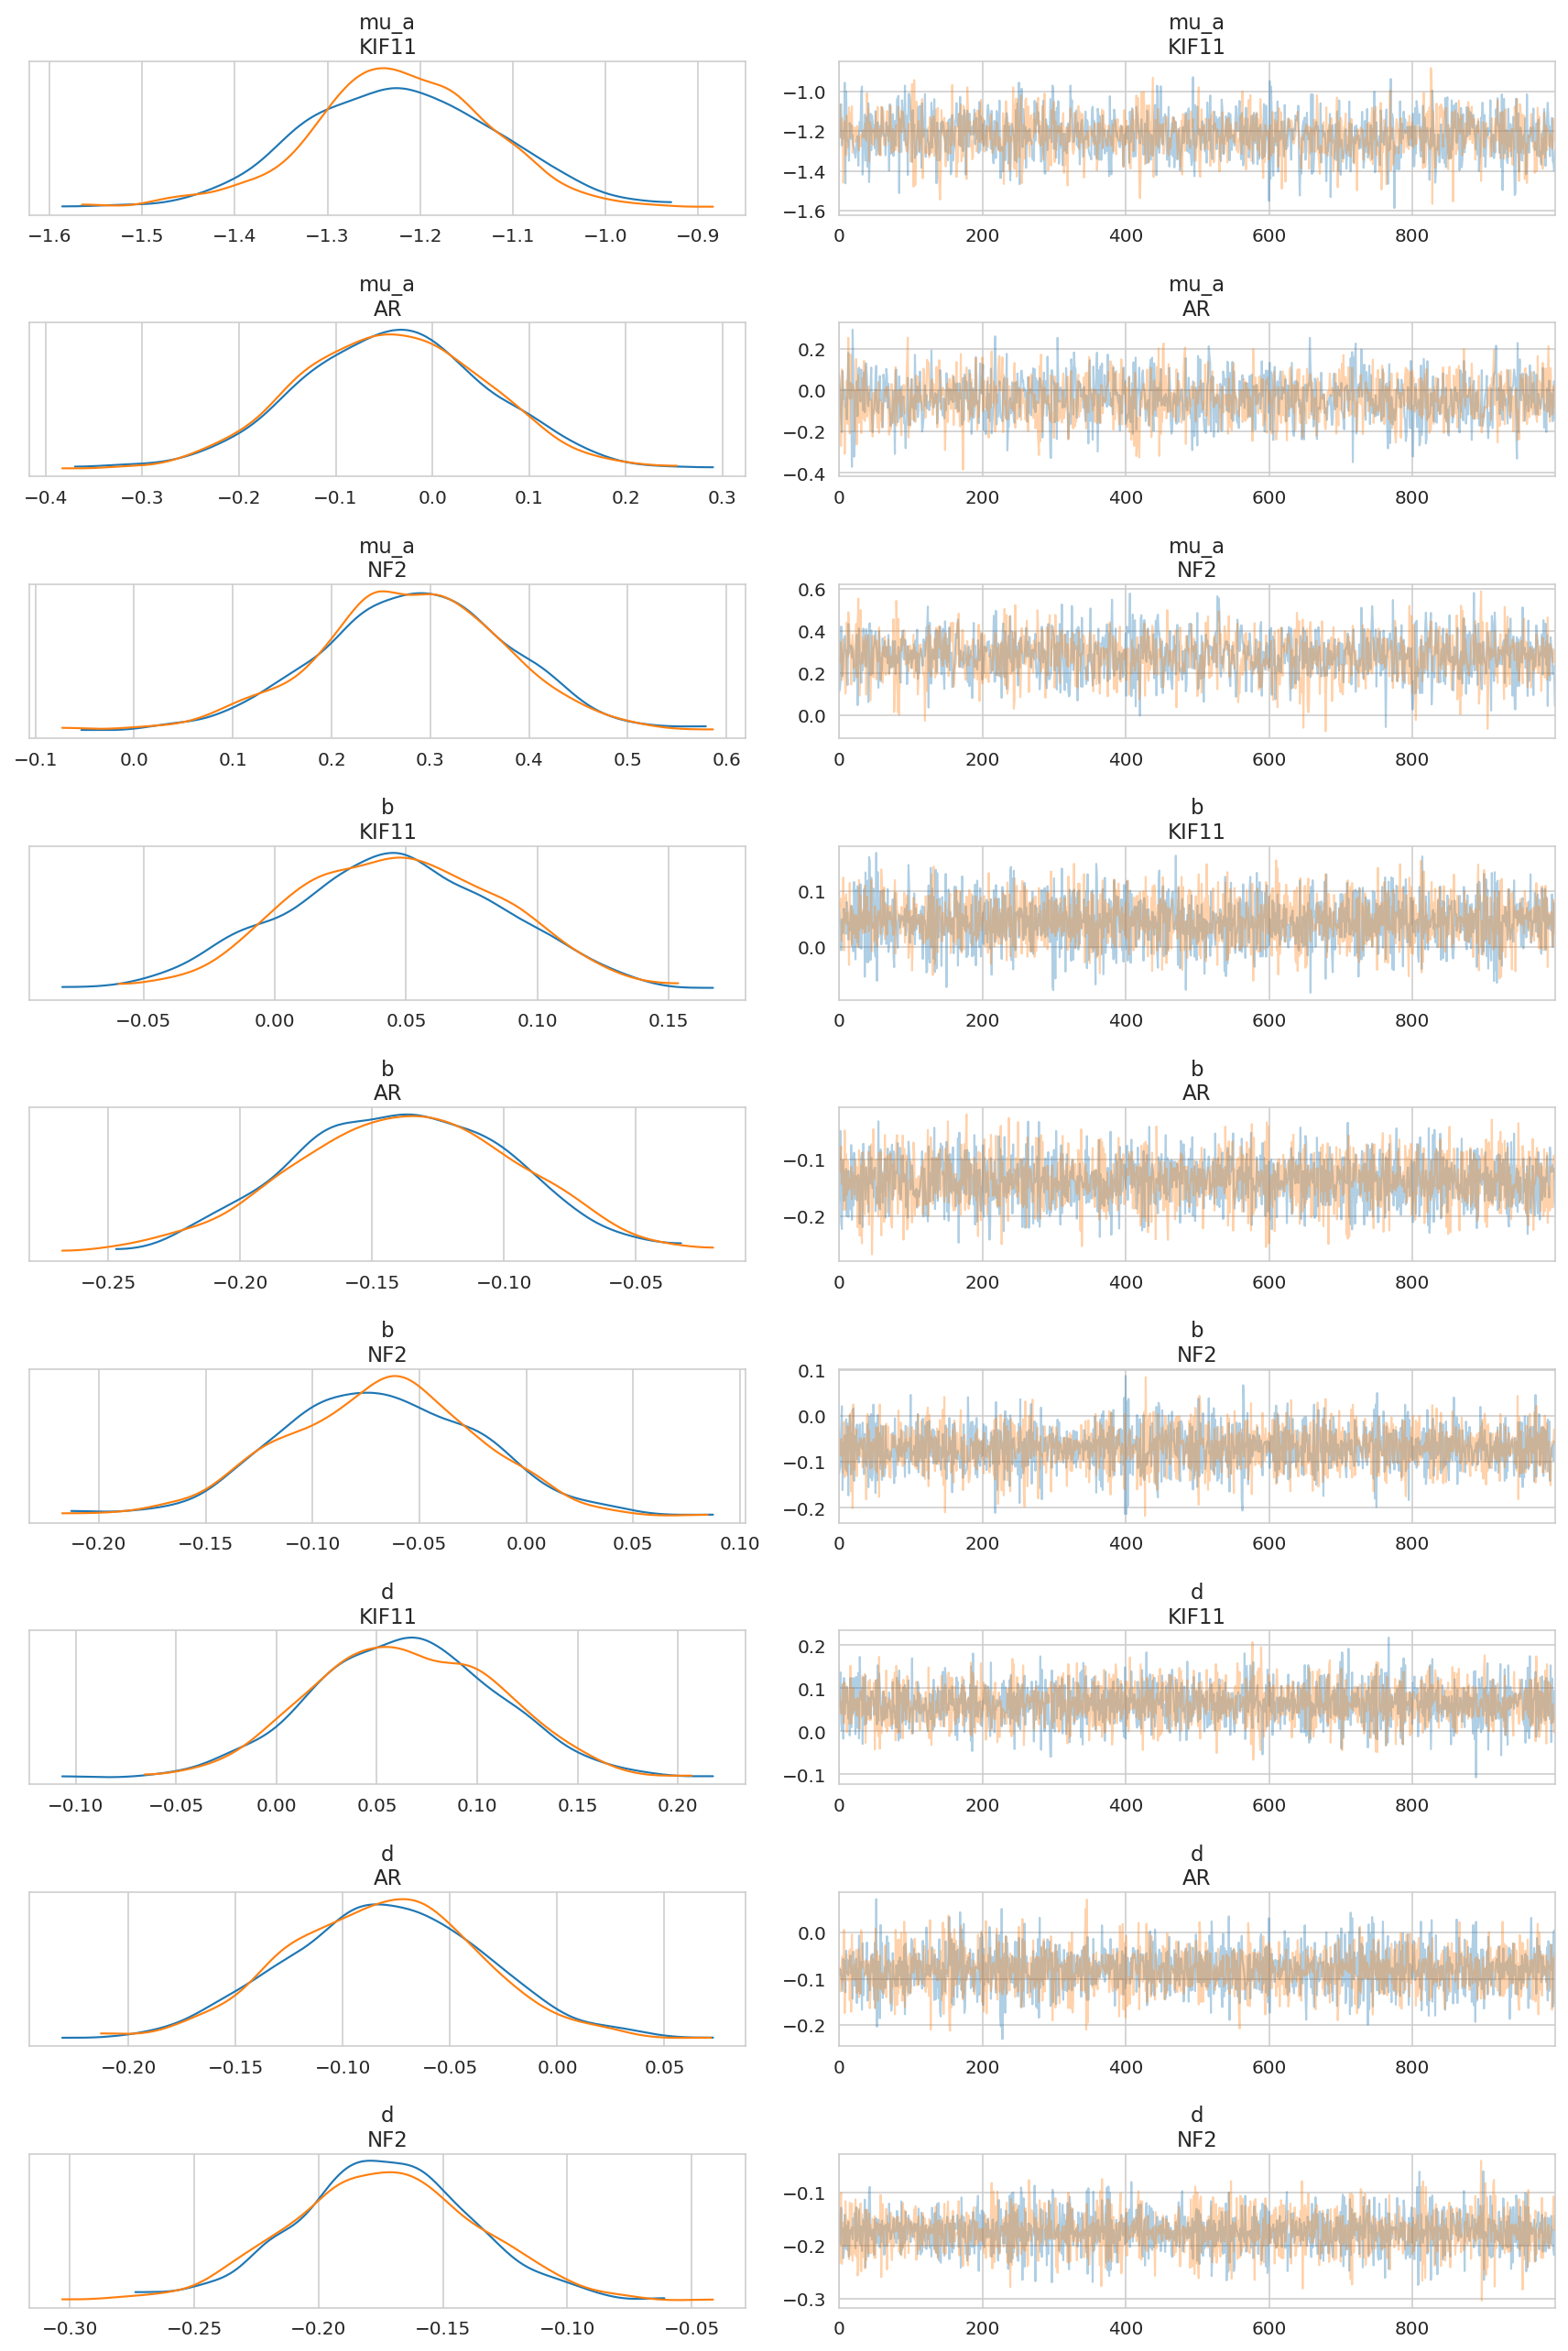

In [35]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace, var_names=["mu_a", "b", "d"], coords={"gene": example_genes}, compact=False
)
plt.tight_layout()
plt.show()

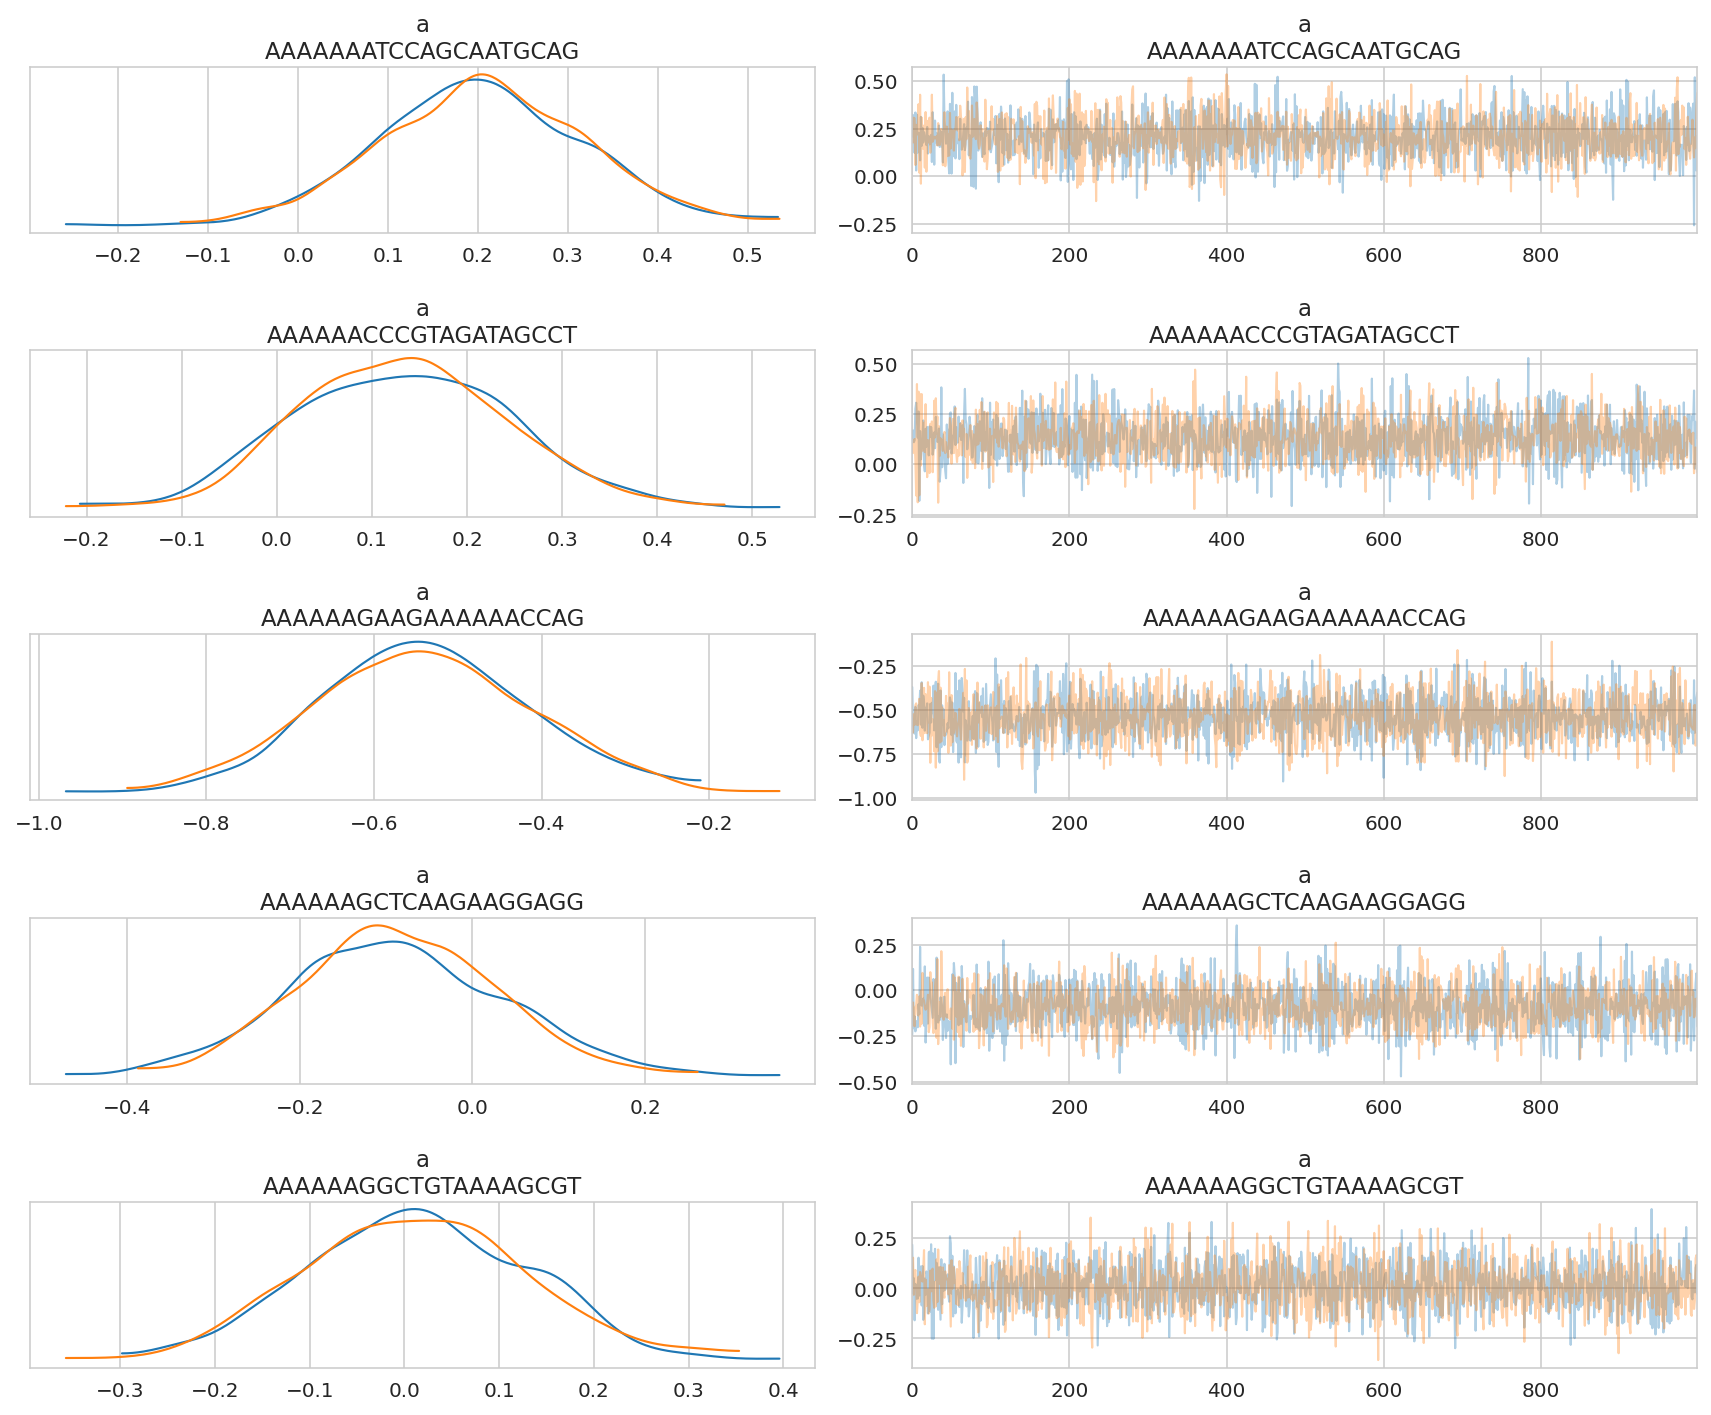

In [36]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

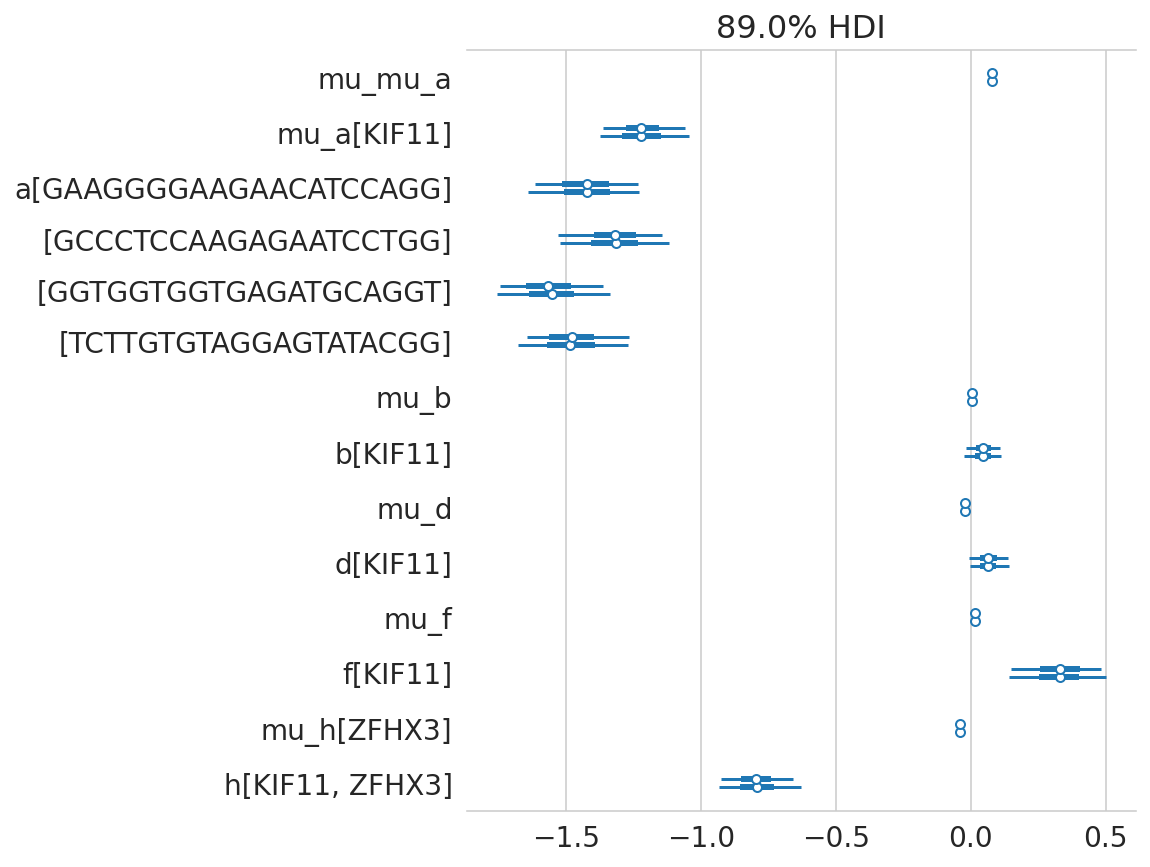

In [37]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "mu_d",
        "d",
        "mu_f",
        "f",
        "mu_h",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

In [38]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
5      sigma_a  0.106  0.106     0.000      0.212      0.053    0.040   
7   sigma_mu_a  0.118  0.118     0.000      0.237      0.059    0.045   
8      sigma_b  0.029  0.029     0.000      0.058      0.014    0.011   
9      sigma_d  0.025  0.025     0.000      0.051      0.013    0.010   
10     sigma_f  0.303  0.325     0.086      0.865      0.162    0.124   
11  sigma_h[0]  0.099  0.066     0.007      0.163      0.033    0.025   

    ess_bulk  ess_tail  r_hat    var_name  
5        5.0      16.0   2.23     sigma_a  
7        5.0      20.0   2.23  sigma_mu_a  
8        5.0      32.0   2.10     sigma_b  
9        6.0      51.0   1.75     sigma_d  
10       5.0      11.0   2.74     sigma_f  
11       5.0      11.0   2.74     sigma_h

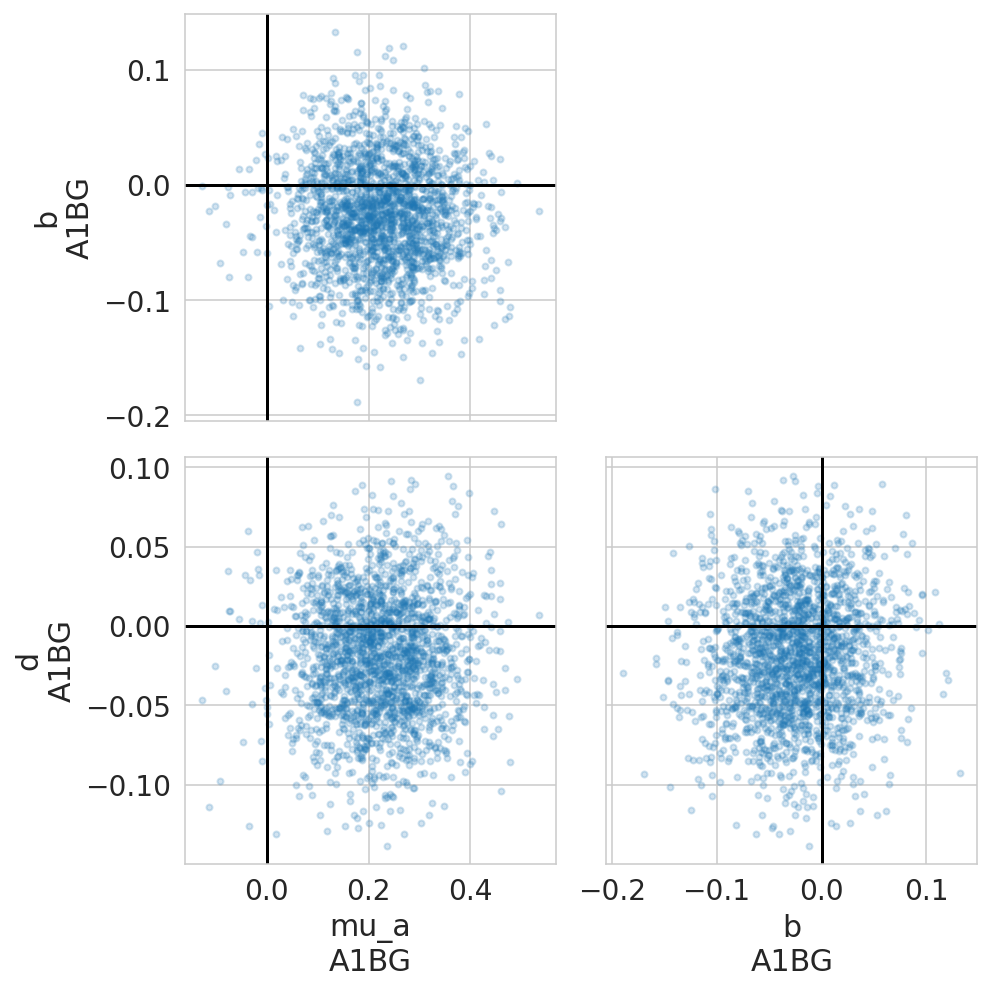

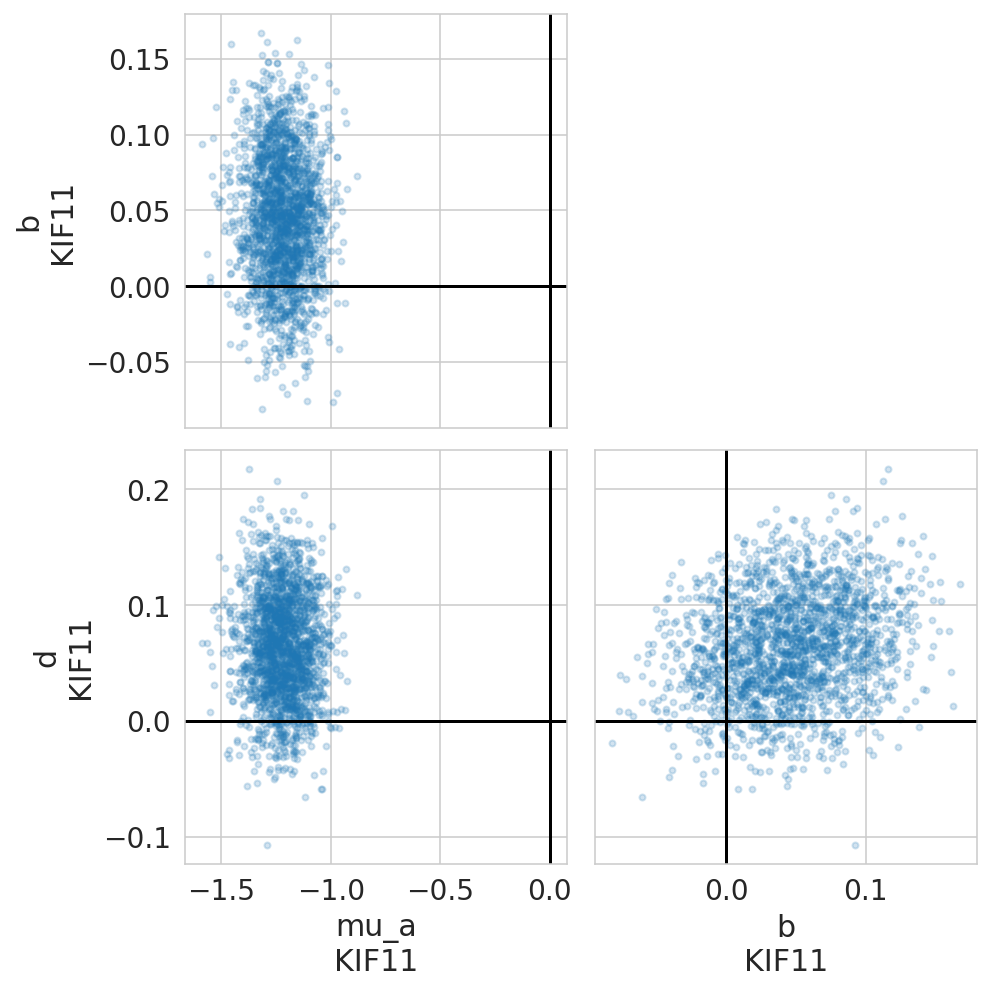

In [39]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

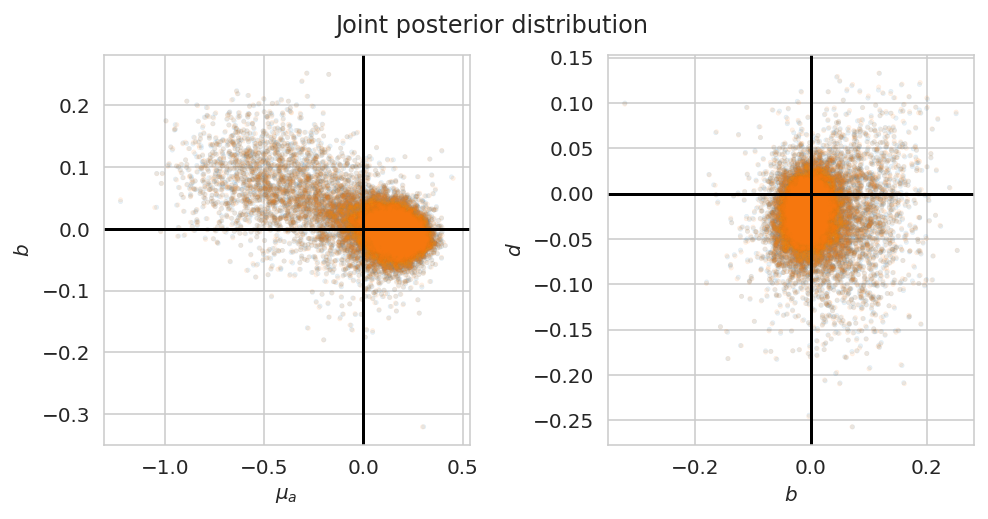

In [40]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [41]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1] -0.380  0.014    -0.403     -0.358   0   1   
genes_chol_cov_corr[0, 2]  0.106  0.016     0.083      0.134   0   2   
genes_chol_cov_corr[0, 3] -0.476  0.034    -0.528     -0.419   0   3   
genes_chol_cov_corr[0, 4]  0.843  0.010     0.828      0.859   0   4   
genes_chol_cov_corr[1, 0] -0.380  0.014    -0.403     -0.358   1   0   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1   
genes_chol_cov_corr[1, 2] -0.014  0.021    -0.050      0.018   1   2   
genes_chol_cov_corr[1, 3]  0.366  0.054     0.284      0.454   1   3   
genes_chol_cov_corr[1, 4] -0.538  0.017    -0.565     -0.512   1   4   
genes_chol_cov_corr[2, 0]  0.106  0.016     0.083      0.134   2   0   
genes_chol_cov_corr[2, 1] -0.014  0.021    -0.050      0.018   2   1   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2   
genes_chol_cov_corr[2, 3] -0.102  0.049    -0.181     -0.024   2   3   
genes_chol_cov_corr[2, 4]  0.123  0.017     0.093      0.148   2   4   
genes_chol_cov_corr[3, 0] -0.476  0.034    -0.528     -0.419   3   0   
genes_chol_cov_corr[3, 1]  0.366  0.054     0.284      0.454   3   1   
genes_chol_cov_corr[3, 2] -0.102  0.049    -0.181     -0.024   3   2   
genes_chol_cov_corr[3, 3]  1.000  0.000     1.000      1.000   3   3   
genes_chol_cov_corr[3, 4] -0.664  0.028    -0.705     -0.617   3   4   
genes_chol_cov_corr[4, 0]  0.843  0.010     0.828      0.859   4   0   
genes_chol_cov_corr[4, 1] -0.538  0.017    -0.565     -0.512   4   1   
genes_chol_cov_corr[4, 2]  0.123  0.017     0.093      0.148   4   2   
genes_chol_cov_corr[4, 3] -0.664  0.028    -0.705     -0.617   4   3   
genes_chol_cov_corr[4, 4]  1.000  0.000     1.000      1.000   4   4   

                                 p1        p2  
genes_chol_cov_corr[0, 0]      mu_a      mu_a  
genes_chol_cov_corr[0, 1]      mu_a         b  
genes_chol_cov_corr[0, 2]      mu_a         d  
genes_chol_cov_corr[0, 3]      mu_a         f  
genes_chol_cov_corr[0, 4]      mu_a  h[ZFHX3]  
genes_chol_cov_corr[1, 0]         b      mu_a  
genes_chol_cov_corr[1, 1]         b         b  
genes_chol_cov_corr[1, 2]         b         d  
genes_chol_cov_corr[1, 3]         b         f  
genes_chol_cov_corr[1, 4]         b  h[ZFHX3]  
genes_chol_cov_corr[2, 0]         d      mu_a  
genes_chol_cov_corr[2, 1]         d         b  
genes_chol_cov_corr[2, 2]         d         d  
genes_chol_cov_corr[2, 3]         d         f  
genes_chol_cov_corr[2, 4]         d  h[ZFHX3]  
genes_chol_cov_corr[3, 0]         f      mu_a  
genes_chol_cov_corr[3, 1]         f         b  
genes_chol_cov_corr[3, 2]         f         d  
genes_chol_cov_corr[3, 3]         f         f  
genes_chol_cov_corr[3, 4]         f  h[ZFHX3]  
genes_chol_cov_corr[4, 0]  h[ZFHX3]      mu_a  
genes_chol_cov_corr[4, 1]  h[ZFHX3]         b  
genes_chol_cov_corr[4, 2]  h[ZFHX3]         d  
genes_chol_cov_corr[4, 3]  h[ZFHX3]         f  
genes_chol_cov_corr[4, 4]  h[ZFHX3]  h[ZFHX3]

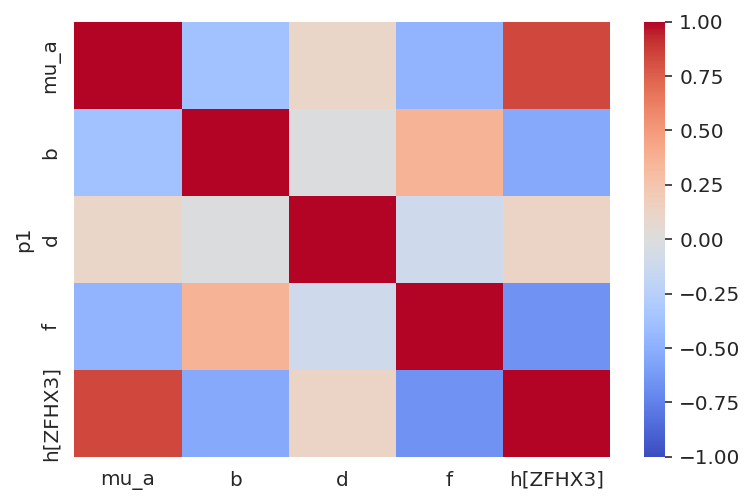

In [42]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [43]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

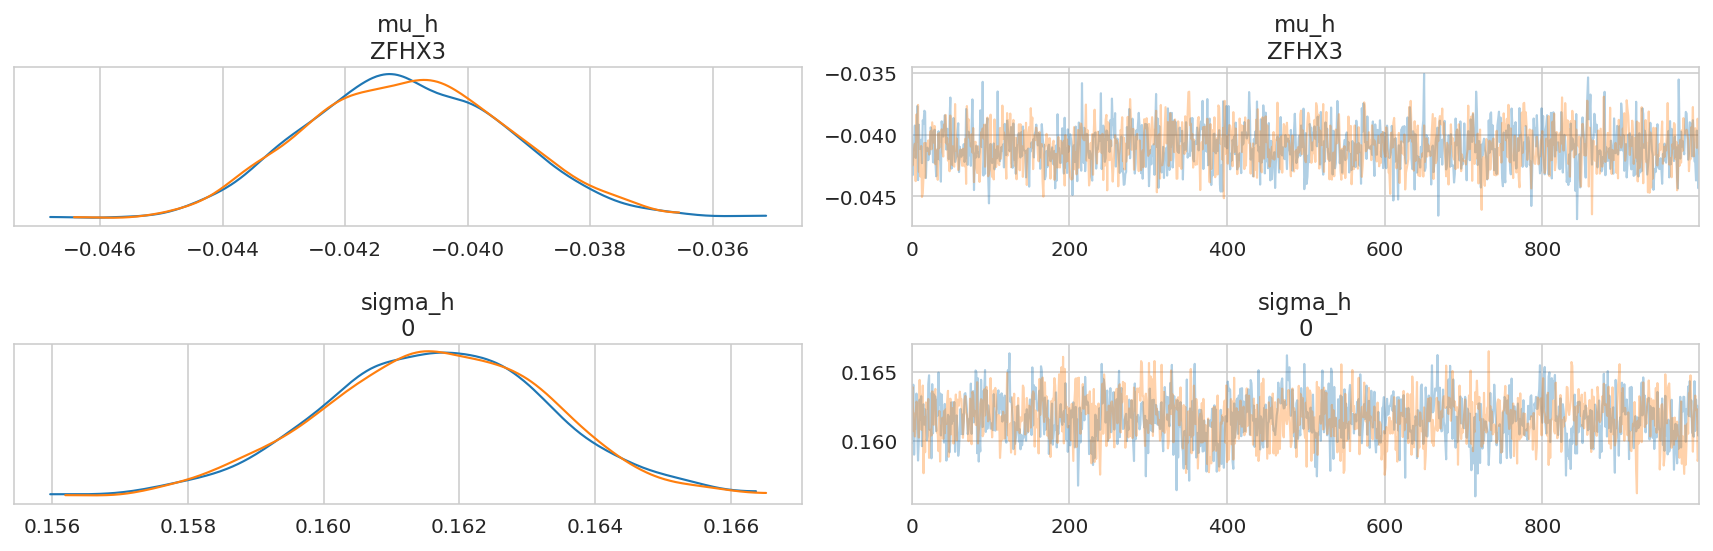

In [44]:
az.plot_trace(trace, var_names=["mu_h", "sigma_h"], compact=False)
plt.tight_layout()
plt.show()

In [45]:
h_post_summary = az.summary(trace, var_names=["h"], kind="stats").pipe(
    extract_coords_param_names, names=["hugo_symbol", "cancer_gene"]
)
h_post_summary.head()

mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol cancer_gene
h[A1BG, ZFHX3]     0.034  0.083    -0.099      0.164        A1BG       ZFHX3
h[A1CF, ZFHX3]     0.083  0.074    -0.036      0.198        A1CF       ZFHX3
h[A2M, ZFHX3]      0.070  0.084    -0.062      0.207         A2M       ZFHX3
h[A2ML1, ZFHX3]   -0.043  0.074    -0.160      0.077       A2ML1       ZFHX3
h[A3GALT2, ZFHX3] -0.012  0.071    -0.121      0.108     A3GALT2       ZFHX3

In [46]:
h_post_summary.sort_values("mean").pipe(head_tail, n=5)

mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol cancer_gene
h[KIF11, ZFHX3]    -0.796  0.090    -0.944     -0.657       KIF11       ZFHX3
h[ELL, ZFHX3]      -0.791  0.080    -0.912     -0.657         ELL       ZFHX3
h[TRNT1, ZFHX3]    -0.766  0.082    -0.888     -0.633       TRNT1       ZFHX3
h[LONP1, ZFHX3]    -0.753  0.086    -0.888     -0.616       LONP1       ZFHX3
h[ATP6V1B2, ZFHX3] -0.742  0.078    -0.867     -0.623    ATP6V1B2       ZFHX3
h[CHMP1B, ZFHX3]    0.194  0.067     0.088      0.303      CHMP1B       ZFHX3
h[AFF4, ZFHX3]      0.218  0.073     0.104      0.332        AFF4       ZFHX3
h[ELOA, ZFHX3]      0.238  0.071     0.122      0.348        ELOA       ZFHX3
h[TP53, ZFHX3]      0.268  0.072     0.155      0.381        TP53       ZFHX3
h[EP300, ZFHX3]     0.468  0.073     0.349      0.584       EP300       ZFHX3

In [47]:
mu_h_post_summary = az.summary(trace, var_names="mu_h", kind="stats").pipe(
    extract_coords_param_names, names=["cancer_gene"]
)
mu_h_post_summary

mean     sd  hdi_5.5%  hdi_94.5% cancer_gene
mu_h[ZFHX3] -0.041  0.002    -0.044     -0.039       ZFHX3

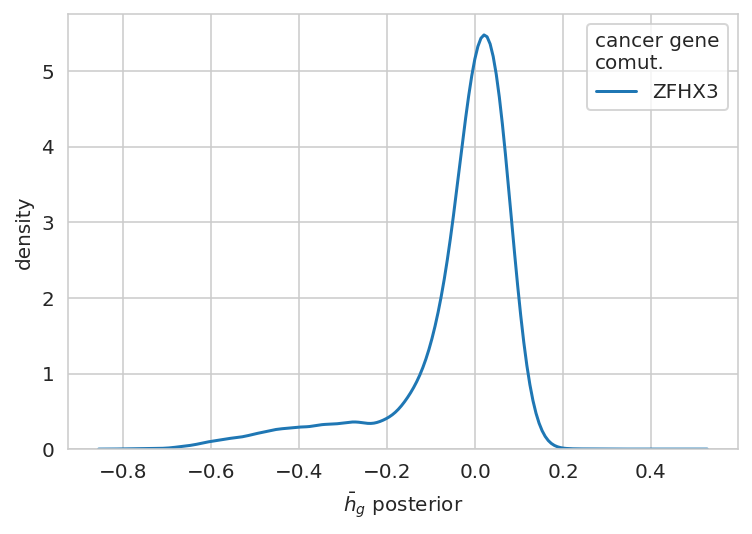

In [48]:
ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

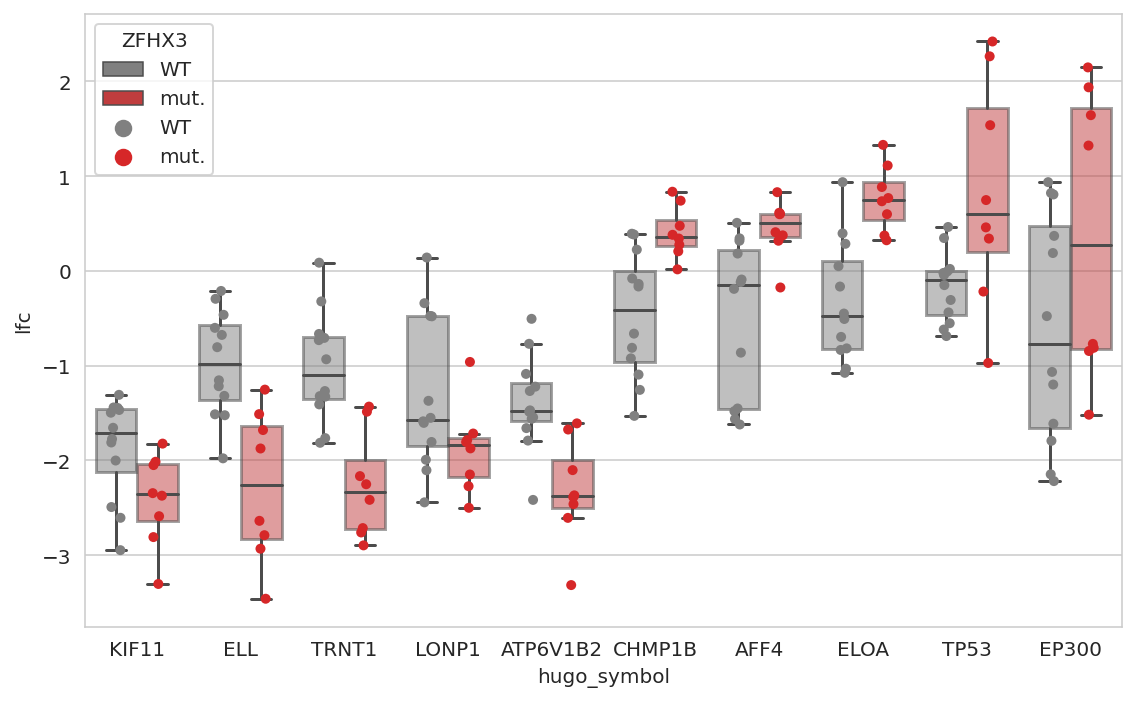

In [49]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    ax.get_legend().set_title(cg)

plt.tight_layout()
plt.show()

In [50]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

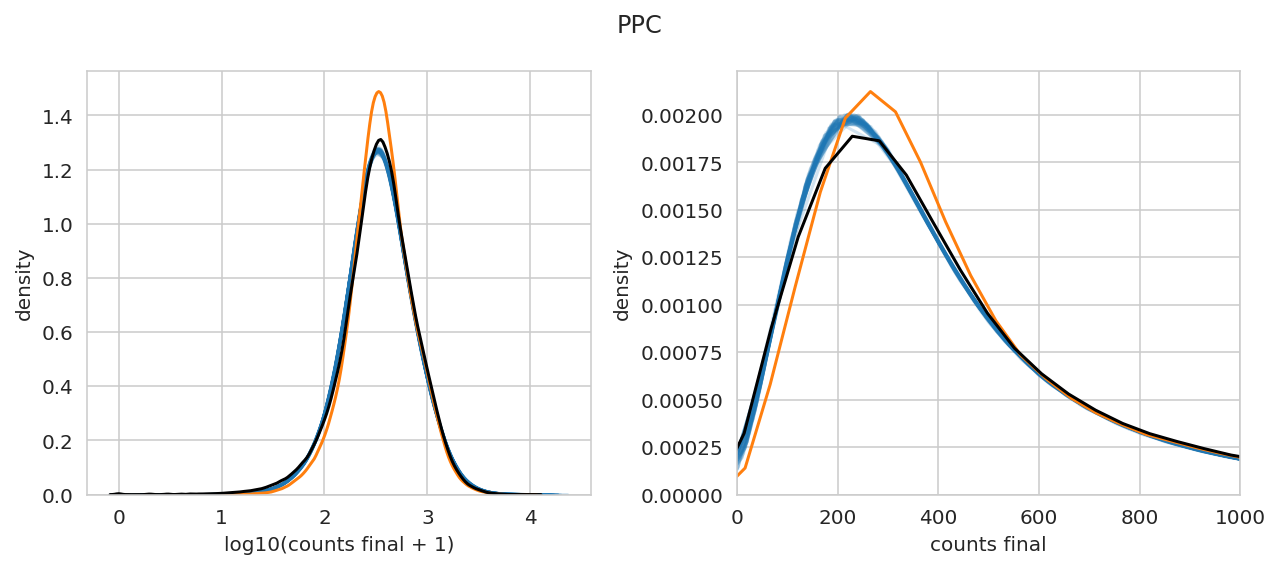

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [52]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 21.09 minutes


In [53]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-27

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-162.o2.rc.hms.harvard.edu

Git branch: simplify

seaborn   : 0.11.2
qnorm     : 0.8.1
numpy     : 1.22.4
arviz     : 0.12.1
matplotlib: 3.5.2
pandas    : 1.4.3

